In [152]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.decomposition import PCA

<h4>Data processing for machine learning algorithm</h4>

In [153]:
df=pd.read_csv('final_data.csv')
del df['Unnamed: 0']
del df['boolDeadRelations']
del df['age']
del df['isNoble']

df.set_index('name',inplace=True)

# get dummy varibles for ordinal varibles
culture_dummy=pd.get_dummies(df['culture'],prefix='Culture') #Nan value will be ingored automatically
df[culture_dummy.columns]=culture_dummy
del df['culture']

house_dummy=pd.get_dummies(df['house'],prefix='House')
df[house_dummy.columns]=house_dummy
del df['house']

identity_dummy=pd.get_dummies(df['identity'])
df[identity_dummy.columns]=identity_dummy
del df['identity']  
del df['lord']  #delete one column to eliminate the linear relationships
print(df.shape)
#get the attribute set and label set
X=df.drop('isAlive',axis=1)
Y=df['isAlive']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15)
print(X_train.shape)
print(X_test.shape)

(1946, 384)
(1654, 383)
(292, 383)


In [154]:
#just write the X,Y with the best accuracy

#X_train=pd.read_csv('X_train.csv',index_col='name')
#X_test=pd.read_csv('X_test.csv',index_col='name')
#Y_train=pd.read_csv('Y_train.csv',index_col='name').values.ravel()
#Y_test=pd.read_csv('Y_test.csv',index_col='name').values.ravel()

In [155]:
# use PCA method to lower the dimension
pca = PCA(0.95)
x_total = df.drop(columns=['isAlive'])
lower_dimensional_x = pca.fit_transform(x_total)
df_pca_features = pd.DataFrame(data=lower_dimensional_x ,
          index=list(df.index),
          columns=np.arange(lower_dimensional_x.shape[1]))
df_pca_features['isAlive'] = df[['isAlive']].values
df_concat = df_pca_features
# df_concat = pd.concat([df_pca_features,pd.DataFrame(df[['isAlive']])])
# print(df_concat.shape)
train, test = train_test_split(df_concat,test_size=0.15)
x_train_pca = train.drop(columns=['isAlive'])
y_train_pca = train[['isAlive']]
x_test_pca = test.drop(columns=['isAlive'])
y_test_pca = test[['isAlive']]
y_train_pca = y_train_pca.values.ravel()
y_test_pca = y_test_pca.values.ravel()
print(x_train_pca.shape)
print(x_test_pca.shape)

(1654, 89)
(292, 89)


In [156]:
print(x_train_pca.head())

                      0         1         2         3         4         5   \
Porther        -0.287910  0.369574  0.882353  0.766061  0.640754 -0.403978   
Sandor Clegane  0.835061 -1.137011  0.772735 -0.166166 -0.002711  0.479769   
Ternesio Terys -0.346557 -0.039865  0.220106 -0.124746 -0.458654  0.299512   
Uthor Tollett  -0.348573  0.389020 -1.139887 -0.199940  0.052617 -0.078978   
Mya Stone      -0.195595 -0.958942  0.047604  1.166886 -0.317197 -0.060888   

                      6         7         8         9   ...        79  \
Porther        -0.063405 -0.850606  0.108678  0.271116  ... -0.012489   
Sandor Clegane  0.494958 -0.277665 -0.076102  0.025829  ...  0.001249   
Ternesio Terys -0.626689  0.561232  0.450610 -0.075081  ...  0.011656   
Uthor Tollett   0.109145  0.020441  0.142547  0.291440  ... -0.005413   
Mya Stone       0.374903 -0.545208 -0.148944  0.234542  ... -0.007397   

                      80        81        82        83        84        85  \
Porther       

<h4>K_nearest neighbors algorithm</h4>

In [157]:
base_model=KNeighborsClassifier(n_neighbors=3)
score=validate_model(base_model,5,x_train_pca,y_train_pca)  

In [158]:
def validate_model(model,K,X,Y):    #cross validation
    folder=KFold(K,shuffle=True)
    folds=folder.split(X,Y)
    val_error=0.0
    fold_count=0
    for fold in folds:
        train_idx,val_idx=fold
        x_train=X.iloc[train_idx]
        y_train=Y[train_idx]
        x_val=X.iloc[val_idx]
        y_val=Y[val_idx]     
        model.fit(x_train,y_train)
        y_pred=model.predict(x_val)
        val_err=np.mean(y_val==y_pred)
        val_error+=val_err
        fold_count+=1
    return val_error/K

In [159]:
#choose the best k for the model
accuracy=np.array([])  
for k in range(3,20):
    base_model=KNeighborsClassifier(n_neighbors=k)
    score=validate_model(base_model,5,x_train_pca,y_train_pca)  #use 5-fold
    accuracy=np.append(accuracy,score)

the best_k is 8
the accuracy of knn is 0.773972602739726
[[ 33  24]
 [ 42 193]]


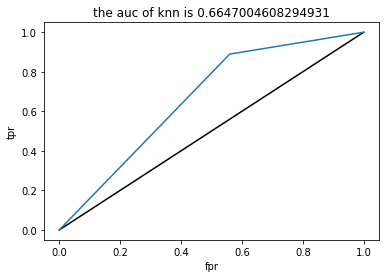

In [160]:
best_k=accuracy.argmax()+3
print(f'the best_k is {best_k}')
knn_best_model=KNeighborsClassifier(n_neighbors=best_k).fit(x_train_pca,y_train_pca)
Y_pre=knn_best_model.predict(x_test_pca)
print(f'the accuracy of knn is {np.mean(Y_pre==y_test_pca)}')
matrix=confusion_matrix(Y_pre,y_test_pca)
print(matrix)
(fpr, tpr, thresholds) = roc_curve(y_test_pca,Y_pre)
area = auc(fpr,tpr)
plt.title(f'the auc of knn is {area}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr,tpr)

<h4>Naive Bayes<h4>

In [64]:
NB_model1 = MultinomialNB(alpha=1) #use Multinomial Naive Bayes, let alpha=1 (Laplace Smoothing)
NB_model1.fit(X_train,Y_train)
NB_model2 = BernoulliNB() #use BernouliNB to predict
NB_model2.fit(X_train,Y_train) 
print(accuracy_score(Y_test,NB_model1.predict(X_test)))
print(accuracy_score(Y_test,NB_model2.predict(X_test))) 
#contrast

0.7705479452054794
0.7636986301369864


<h4>Decision Tree<h4>

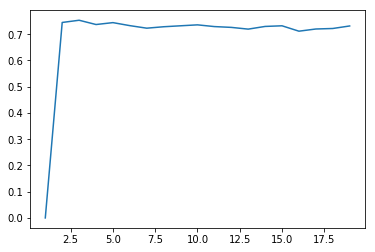

In [161]:
performance=np.repeat(0.0,19)
for k in range(2,20): #We are trying to find the best depth of the decision tree in case overfitting 
    decision_tree_model = tree.DecisionTreeClassifier(max_depth=k) 
    avg_performance=(validate_model(decision_tree_model,k,x_train_pca,y_train_pca))
    performance[k-1]=avg_performance
outcomes=np.arange(1,20)
plt.plot(outcomes,performance)

In [162]:
decision_tree_model = tree.DecisionTreeClassifier(max_depth=10)
#Roughly, the best max depth is 10
decision_tree_model.fit(x_train_pca,y_train_pca)
accuracy_score(y_test_pca, decision_tree_model.predict(x_test_pca))

0.7842465753424658

In [136]:
# feature_names = [key for key in df_concat if not key=='isAlive']
# from IPython.display import Image
# dot_data = tree.export_graphviz(decision_tree_model, out_file=None,feature_names=feature_names)
# import pydotplus

# graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

# Image(graph.create_png())
# #visualization 

<h4>Random Forrest<h4>

In [163]:
from sklearn.ensemble import RandomForestClassifier

RFC_model = RandomForestClassifier(n_estimators=10)
RFC_model.fit(x_train_pca,y_train_pca)
accuracy_score(y_test_pca, RFC_model.predict(x_test_pca))
#random forrest's algorithm

0.8184931506849316

<h4>SVM<h4>

In [164]:
from sklearn.svm import SVC

In [166]:
performance=np.repeat(0.0,50)
k=0
for c in np.arange(2,102,2):
    SVM_model = SVC(kernel='rbf',C=c,gamma='auto')
    SVM_model.fit(x_train_pca,y_train_pca)
    performance[k]=accuracy_score(y_test_pca, SVM_model.predict(x_test_pca))
    k+=1
#we will use this loop to determine c value(regularizaiton)

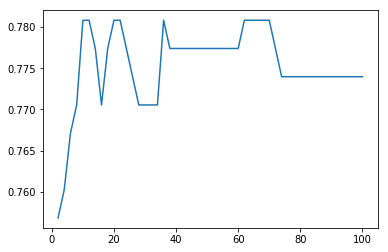

In [167]:
outcomes=np.arange(2,102,2)
plt.plot(outcomes,performance)

In [168]:
SVM_model = SVC(kernel='rbf',C=20,gamma='auto')
SVM_model.fit(x_train_pca,y_train_pca)
accuracy_score(y_test_pca, SVM_model.predict(x_test_pca))
#seems 20 is a good choise

0.7808219178082192

In [169]:
confusion_matrix(y_test_pca,SVM_model.predict(x_test_pca))

array([[ 15,  60],
       [  4, 213]])

<h4>Logistic Regression</h4>

In [170]:
Logis_model=LogisticRegression(solver='liblinear').fit(x_train_pca,y_train_pca)
y_pre=Logis_model.predict(x_test_pca)
print(f'the accuracy of LogisticRegression is {np.mean(y_pre==y_test_pca)}')

the accuracy of LogisticRegression is 0.773972602739726


<BarContainer object of 10 artists>

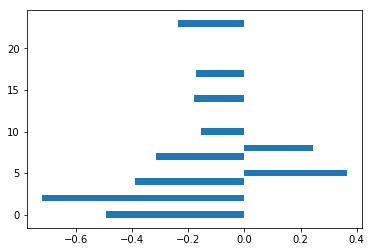

In [171]:
#calculate the importance of each attribute
feature_importance=Logis_model.coef_.ravel()*np.std(x_train_pca,axis=0)
#find the most ten important factors
index=feature_importance[abs(feature_importance).argsort()[::-1][:10]].index
plt.barh(index,feature_importance[abs(feature_importance).argsort()[::-1][:10]])

[[ 26  17]
 [ 49 200]]


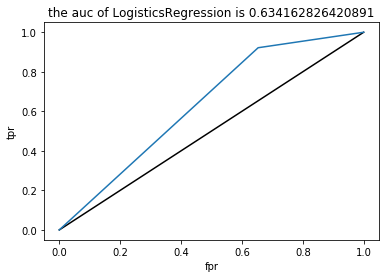

In [172]:
matrix=confusion_matrix(y_pre,y_test_pca)
print(matrix)
(fpr, tpr, thresholds) = roc_curve(y_test_pca,y_pre)
area = auc(fpr,tpr)
plt.title(f'the auc of LogisticsRegression is {area}')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr,tpr)

<h4>Predict the death probability for the main characters</h4>

In [173]:
#Get the data we need to predict
name=['Sansa Stark','Tyrion Lannister','Jon Snow','Daenerys Targaryen','Jaime Lannister','Bran Stark', 'Arya Stark','Cersei Lannister']
X_prediction=df_concat.loc[name].drop('isAlive',axis=1)
Y_prediction=df_concat.loc[name]['isAlive']
death_prob=Logis_model.predict_proba(X_prediction)
pd.DataFrame(death_prob,index=name,columns=['Death','Alive']).sort_values(by='Death')

,Death,Alive
Arya Stark,0.387503,0.612497
Jon Snow,0.414868,0.585132
Sansa Stark,0.420523,0.579477
Bran Stark,0.534434,0.465566
Cersei Lannister,0.700655,0.299345
Jaime Lannister,0.748176,0.251824
Daenerys Targaryen,0.876722,0.123278
Tyrion Lannister,0.880430,0.119570


<h4>Try to use oversampling to modify the imbalanced dataset

In [174]:
# #use random oversample to modify the data
# from imblearn.over_sampling import RandomOverSampler,SMOTE
# from imblearn.pipeline import make_pipeline as make_imb_pipeline
# ros = RandomOverSampler()
# X_train_oversample, Y_train_oversample = ros.fit_sample(x_train_pca, y_train_pca)
# oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression(solver='liblinear'))
# scores = cross_validate(oversample_pipe,
#                         x_train_pca, y_train_pca, cv=10,
#                         scoring=('roc_auc', 'average_precision'))
# scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [151]:
# #use smote method to modify the data
# oversample_pipe = make_imb_pipeline(SMOTE(), LogisticRegression(solver='liblinear'))
# scores = cross_validate(oversample_pipe,
#                         X_train, Y_train, cv=10,
#                         scoring=('roc_auc', 'average_precision'))
# scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()